# Fashion MNIST Data Preparation

First, let's get the data prepared. Luckily, PyTorch has a handy function to download it for us in its [torchvision.datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar) package. Go ahead and get the 
required torchvision version by running the following; you'll only need to do so once, and then click Runtime->Restart runtime to move on. Every time you restart the runtime, you'll need to re-run everything.

In [1]:
# Download Fashion MNIST dataset from PyTorch 
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
                              transforms.Resize((32,32)),
                              transforms.ToTensor(),
                              ])
PATH_TO_STORE_DATA = 'problem2/data/'
dataset_train = torchvision.datasets.FashionMNIST(PATH_TO_STORE_DATA, download=True, train=True, 
                                             transform=transform)
dataset_test = torchvision.datasets.FashionMNIST(PATH_TO_STORE_DATA, download=True, train=False, 
                                            transform=transform)

Processing...
Done!


/Users/yuf/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:299: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272480871/work/torch/csrc/utils/tensor_numpy.cpp:189.)
  return torch.from_numpy(parsed).view(length, num_rows, num_cols)


ain't nobody want to write to it.... no worries

In [89]:
"Why do one wish to reload something?"
from importlib import reload  
import data 

In [95]:
import matplotlib.pyplot as plt
import random
import torch
import torchvision
from torch.utils.data import Dataset
import PIL
import torchvision.transforms as transforms

In [93]:
class MNISTDatasetWrapper(Dataset):
    """
    A Dataset for learning with subsets of the Fashion MNIST dataset for either the
    original labels or labels that describe how the image has been rotated.
    Rotations will be applied clockwise, with a random choice of one of the
    following degrees: [0, 45, 90, 135, 180, 225, 270, 315]

    - original_dataset - the fashion mnist dataset we got with torchvision
    - pct - percent of data to use
    - for_rotation_classification - True=Use rotation labels.
                                    False=Use original classification labels.
    """

    def __init__(self, original_dataset, pct=1.0, for_rotation_classification=False):
        
        # in case we need to get the subset
        self.dataset_size = int(len(original_dataset)*pct)
        self.dataset = torch.utils.data.Subset(original_dataset, random.choices(range(len(original_dataset)), k=self.dataset_size))
        
        self.for_rotation_classification = for_rotation_classification
        self.label_to_class = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
                               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
        # tensor image shapte [B,C,H,W]
        self.imageToTensor = transforms.ToTensor()
        # PIL short for Python Image Library
        self.tensorToImage = transforms.ToPILImage()
        # normalize takes mean, std (given for each channel) (works on tensor only)
        # output[channel] = (input[channel] - mean[channel]) / std[channel]
        self.normalize = transforms.Normalize((0.2859,), (0.3530,))
        # this is literally how you get back the original image tensor
        self.denormalize = transforms.Normalize((-0.2859/0.3530,), (1.0/0.3530,))
        # choices of Rotation Degrees
        self.rot_choices = [0, 45, 90, 135, 180, 225, 270, 315]
        # number of roationa degrees to choose from
        self.num_rot = len(self.rot_choices)

    # dumest request I have seen in my entire life candidate here
    def __len__(self):
        return self.dataset_size

    def __getitem__(self, idx):
        """
        Returns a 32x32 MNIST digit and its corresponding clothes
        label, or if self.for_rotation_classification is true returns
        the image rotated by a random rotation amount from
        self.rot_choices. Note: the label should be a number between 0-7,
        not the number of degrees to rotate by.
        """
        img, label = self.dataset[idx]
        if not self.for_rotation_classification:
            return self.normalize(img), label
        else:
            img = self.tensorToImage(img)
            label = random.choice([i for i in range(self.num_rot)])
            rot_degree = self.rot_choices[label]
            img = img.rotate(rot_degree)
            img = self.normalize(self.imageToTensor(img))
            return img, torch.tensor(label).long()

    def show_batch(self, n=3):
        fig, axs = plt.subplots(n, n)
        fig.tight_layout()
        for i in range(n):
            for j in range(n):
                rand_idx = random.randint(0, len(self)-1)
                img, label = self.__getitem__(rand_idx)
                axs[i, j].imshow(self.tensorToImage(self.denormalize(img)), cmap='gray')
                if not self.for_rotation_classification:
                    axs[i, j].set_title('Label: {0} (#{1})'.format(label.item(), self.label_to_class[label.item()]))
                else:
                    axs[i, j].set_title('Label: {0} ({1} Degrees)'.format(label.item(), label.item()*45))
                axs[i, j].axis('off')

In [96]:
data = reload(data) #reload for making changes during debugging
train_full_dataset = data.MNISTDatasetWrapper(dataset_train, pct=1.0)
test_full_dataset = data.MNISTDatasetWrapper(dataset_test, pct=1.0)
print('Full dataset: {0} Training Samples | {1} Test Samples'.format(
    len(train_full_dataset), len(test_full_dataset)))

train_small_dataset = data.MNISTDatasetWrapper(dataset_train, pct=0.05)
print('Small train dataset: {0} Training Samples'.format(len(train_small_dataset)))

Full dataset: 60000 Training Samples | 10000 Test Samples
Small train dataset: 3000 Training Samples


Let's use the handy show_batch function to get an idea of what's in the dataset:

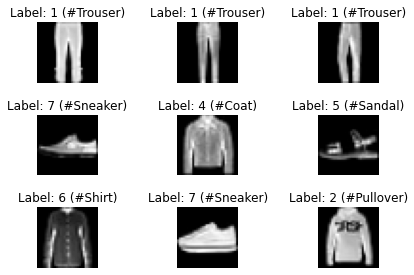

In [97]:
train_full_dataset.show_batch()

# PyTorch Vision Model

Next, we need to define our neural net architectures for training on the data. Because we want to ultimately train for two objectives (clothing type classification and rotation classification), we will do this via several classes so that the weights gotten from representation learning can be re-used later for more efficient clothing classification.
Fill in the marked portions of models.py, and try to execute the following:

In [156]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
from PIL import Image

In [157]:
class ImageEmbedNet(nn.Module):
    """
    A set of Conv2D layers to take features of an image and create an embedding.
    The network has the following architecture:
    * a 2D convolutional layer with 1 input channels, 16 output channels,
      kernel size 5, stride 1, and padding 2
    * an ReLU non-linearity
    * a 2D max pool layer with kernel size 2 and stride 2
    * a 2D convolutional layer with 16 input channels and 32 output channels, 
      kernel size 5, stride 1, and padding 2
    * an ReLU non-linearity
    * a 2D max pool layer with kernel size 2 and stride 2
    * a Flatten layer
    """
    def __init__(self):
        super(ImageEmbedNet, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1,16,5,stride=1,padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2,stride=2),
            nn.Conv2d(16,32,5,stride=1,padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2,stride=2),
            # I am flattening all dimensions except the batch_dim
            nn.Flatten()
        )

    def forward(self, image):
        # need to ensure the image is a Tensor
        return self.model(image)

In [158]:
class ClassifyNet(nn.Module):
    """
    A set of FC layers to take features of a image a classify some output.
    The network has the following architecture:
    * a linear layer with input side input_size and output size hidden_layer_size
    * an ReLU non-linearity
    * a linear layer with input side hidden_layer_size and output size hidden_layer_size
    * an ReLU non-linearity
    * a linear layer with input side hidden_layer_size and output size output_size
    """
    def __init__(self, output_size,
                       input_size=2048,
                       hidden_layer_size=25):
        super(ClassifyNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_layer_size),
            nn.ReLU(),
            nn.Linear(hidden_layer_size, hidden_layer_size),
            nn.ReLU(),
            nn.Linear(hidden_layer_size, output_size)
        )

    def forward(self, image_features):
        return self.model(image_features)

In [182]:
class ImageClassifyModel(object):
    """
    A small class to combine image embedding and classification 
    """
    def __init__(self, image_embed_net,
                       image_classify_net,
                       exclude_embed_params=False):
        self.image_embed_net = image_embed_net 
        self.image_classify_net = image_classify_net
        self.parameters = []
        '''
        TODO if exclude_embed_params, have parameters be the parameters from
        image_classify_net, otherwise have it be a list of the parameters of
        both image_embed_net and image_classify_net
        
        I suspect this is NOT the Correct way of doing it (Or what it's Asking)
        '''
        if exclude_embed_params:
            self.parameters.append(self.image_classify_net.parameters())
        else:
            self.parameters.append(self.image_embed_net.parameters())
            self.parameters.append(self.image_classify_net.parameters())
      
    def classify(self, image):
        image_features = self.image_embed_net(image)
        return self.image_classify_net(image_features)

In [183]:
import models
models = reload(models) #reload for making changes during debugging

#image_embed_net = models.ImageEmbedNet().cuda()
#classify_net = models.ClassifyNet(10).cuda()

image_embed_net = ImageEmbedNet()
classify_net = ClassifyNet(10)
mnist_classify_model = ImageClassifyModel(image_embed_net, classify_net)

# Training for Fashion MNIST Class Prediction

Let's now implement a method for training on the dataset with the model we defined above. We will create a re-usable function that can be used for both representation learning and learning to classify Fashion MNIST images. This will involve the following:
*   Given the dataset, creating a PyTorch [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) which can take care of shuffling the dataset as well as combining multiple image.
*   Creating a PyTorch loss function that can be used for optimizing our model for the task of classification. We will use the standard [Cross Entropy Loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).
*   Creating a PyTorch [optimizer](https://pytorch.org/docs/stable/optim.html) to update the weights of the model given the loss computation.
*   Lastly, our two training loops (one for the number of epochs, and one for iterating over the dataset) in which we use all the above to train the model.

Fill in the relevant portions of code in training.py, and try to execute the following to go ahead and train on the Fashion MNIST classification task. If training.py is finished, we now just need to call its train function:

In [217]:
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [242]:
"""
The Training here concerns only the Classification task
"""
def train(dataset, model, batch_size, epochs):
    """
    A function that trains the given model on the provided dataset.
    1. The momentum method in SGD uses running (exponential) average to denoise against the random noise
       and provide better estimate of the gradient (smaller variance estimator somehow, I am not sure if
       it always work)
    """
    # TODO initialize a DataLoader on the dataset with the appropriate batch
    # size and shuffling enabled.
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # TODO initialize this to be a Cross Entropy Classification loss.
    criterion = nn.CrossEntropyLoss()

    # TODO initialize this to be an Stochastic gradient descent optimizer with
    # learning rate set to 0.001 and momentum set to 0.9.
    """
    Are we training on both the embedding and the classifynet or just the classify net?
    """
    params = []
    for param in model.parameters:
        params.append({'params':param})
    optimizer = optim.SGD(params, lr=0.001, momentum=0.9)

    losses = []
    accuracies = []
    for e in range(epochs):
        running_loss = 0
        correct_count = 0
        for images, labels in tqdm.tqdm(data_loader,'Training for one epoch'):
            # Training pass
            optimizer.zero_grad()
            #images_cuda = images
            #labels_cuda = labels

            # Call the model's classify method with images_cuda.
            output = model.classify(images)

            # Call the criterion with the ouput and labels_cuda.
            loss = criterion(output, labels)

            # Calculate accuracy, return the index of maximum values on each batch
            _, predictions = torch.max(output, 1)

            # TODO calculate the number of correctly classified inputs.
            # num_correct = sum(predictions==labels).item()
            num_correct = sum(predictions==labels)

            correct_count += num_correct

            if e > 0: # Don't optimize at epoch 0, to see how model starts
                # Here we use the loss to back propagate errors, and then do an
                # optimization step.

                # Get model weight updates by backpropagating the loss with backward()
                loss.backward()

                # Apply the weight updates with the optimizer with step()
                optimizer.step()

            running_loss += loss.item()

        # Calculate the average loss in this epoch.
        epoch_loss = running_loss / len(dataset)

        # Calculate the float accuracy of this epoch.
        accuracy = correct_count / len(dataset)

        losses.append(epoch_loss)
        accuracies.append(accuracy)
        print("Epoch %d - Training loss: %.3f , Training Accuracy: %.3f\n"%(e, 
                                                                          epoch_loss, 
                                                                          accuracy))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(losses)
    ax2.plot(accuracies)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    plt.show()

Training for one epoch: 100%|██████████| 3750/3750 [00:17<00:00, 210.92it/s]


Epoch 0 - Training loss: 0.144 , Training Accuracy: 0.099



Training for one epoch: 100%|██████████| 3750/3750 [00:36<00:00, 101.37it/s]


Epoch 1 - Training loss: 0.048 , Training Accuracy: 0.715



Training for one epoch: 100%|██████████| 3750/3750 [00:37<00:00, 100.24it/s]


Epoch 2 - Training loss: 0.026 , Training Accuracy: 0.851



Training for one epoch: 100%|██████████| 3750/3750 [00:36<00:00, 101.35it/s]


Epoch 3 - Training loss: 0.021 , Training Accuracy: 0.876



Training for one epoch: 100%|██████████| 3750/3750 [00:36<00:00, 101.68it/s]


Epoch 4 - Training loss: 0.018 , Training Accuracy: 0.892



Training for one epoch: 100%|██████████| 3750/3750 [00:35<00:00, 104.33it/s]


Epoch 5 - Training loss: 0.016 , Training Accuracy: 0.903



Training for one epoch: 100%|██████████| 3750/3750 [00:35<00:00, 105.87it/s]


Epoch 6 - Training loss: 0.015 , Training Accuracy: 0.912



Training for one epoch: 100%|██████████| 3750/3750 [00:36<00:00, 103.58it/s]


Epoch 7 - Training loss: 0.014 , Training Accuracy: 0.919



Training for one epoch: 100%|██████████| 3750/3750 [00:35<00:00, 104.81it/s]


Epoch 8 - Training loss: 0.013 , Training Accuracy: 0.926



Training for one epoch: 100%|██████████| 3750/3750 [00:35<00:00, 104.36it/s]


Epoch 9 - Training loss: 0.012 , Training Accuracy: 0.931



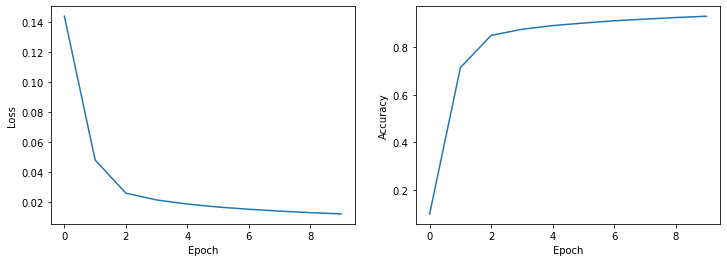

In [227]:
import models
models = reload(models) #reload for making changes during debugging

#image_embed_net = models.ImageEmbedNet().cuda()
#classify_net = models.ClassifyNet(10).cuda()

image_embed_net = ImageEmbedNet()
classify_net = ClassifyNet(10)
mnist_classify_model = ImageClassifyModel(image_embed_net, classify_net)

# obviously we have a bug on the accuracy level
train(train_full_dataset, mnist_classify_model, 16, 10)

You should get training accuracy of around 0.92. With the model now trained, let's implement a test function and call it to see how well it works on the test set. Finish the marked portions in testing.py and run the following:

In [238]:
def test(dataset, model, batch_size):
    # TODO initialize a DataLoader on the dataset with the appropriate batch
    # size and shuffling enabled.
    data_loader = DataLoader(dataset, batch_size, shuffle=True)

    correct_count = 0
    for images, labels in data_loader:
        output = model.classify(images)

        # Calculate accuracy
        _, predictions = torch.max(output, 1)

        # Calculate the number of correctly classified inputs.
        num_correct = sum(predictions==labels)

        correct_count+=num_correct

    # Calculate the float accuracy for the whole dataset.
    accuracy = correct_count / len(dataset)
    print("Testing Accuracy: %.3f"%(accuracy))

In [239]:
import testing

test(test_full_dataset, mnist_classify_model, 16)

Testing Accuracy: 0.887


You should get test set accuracy slighty lower than the train set accuracy. The accuracy is not great; on such simple data it should be fairly easy to get close to perfect accuracy. We'll try to address this with representation learning.

Before that, let's try training on the smaller train set, and see how well the model can work on the test set.

Training for one epoch: 100%|██████████| 188/188 [00:00<00:00, 222.14it/s]


Epoch 0 - Training loss: 0.144 , Training Accuracy: 0.098



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 109.21it/s]


Epoch 1 - Training loss: 0.142 , Training Accuracy: 0.192



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 109.10it/s]


Epoch 2 - Training loss: 0.095 , Training Accuracy: 0.510



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 109.16it/s]


Epoch 3 - Training loss: 0.060 , Training Accuracy: 0.654



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 109.00it/s]


Epoch 4 - Training loss: 0.054 , Training Accuracy: 0.691



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 108.91it/s]


Epoch 5 - Training loss: 0.047 , Training Accuracy: 0.732



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 109.04it/s]


Epoch 6 - Training loss: 0.043 , Training Accuracy: 0.749



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 109.10it/s]


Epoch 7 - Training loss: 0.040 , Training Accuracy: 0.778



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 109.32it/s]


Epoch 8 - Training loss: 0.038 , Training Accuracy: 0.781



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 109.35it/s]


Epoch 9 - Training loss: 0.036 , Training Accuracy: 0.798



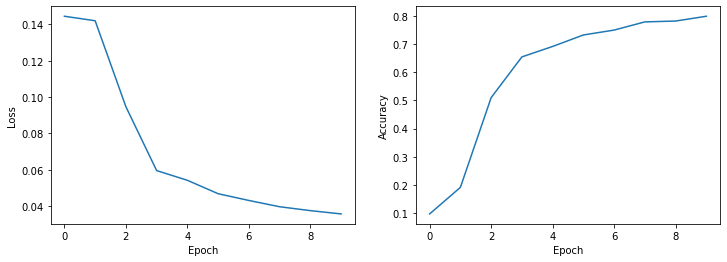

Testing Accuracy: 0.778


In [243]:
image_embed_net = ImageEmbedNet()
classify_net = ClassifyNet(10)
mnist_classify_model = ImageClassifyModel(image_embed_net, classify_net)
train(train_small_dataset, mnist_classify_model, 16, 10)
test(test_full_dataset, mnist_classify_model, 16)

# Representation Learning via Rotation Classification

Now, let's define new datasets for doing our representation learning by predicting the rotation of Fashion MNIST images, and once again call show_batch to get a look at the data:

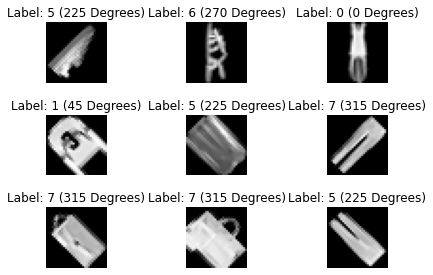

In [245]:
data = reload(data) #reload for making changes during debugging

train_rotation_dataset = MNISTDatasetWrapper(dataset_train, 
                                          pct=1.0, for_rotation_classification=True)
test_rotation_dataset = MNISTDatasetWrapper(dataset_test, 
                                         pct=1.0, for_rotation_classification=True)
train_rotation_dataset.show_batch()

Now, let's train a model on the rotation prediction task by once again using our train function:

Training for one epoch: 100%|██████████| 3750/3750 [00:24<00:00, 156.18it/s]


Epoch 0 - Training loss: 0.130 , Training Accuracy: 0.123



Training for one epoch: 100%|██████████| 3750/3750 [00:43<00:00, 86.13it/s]


Epoch 1 - Training loss: 0.056 , Training Accuracy: 0.662



Training for one epoch: 100%|██████████| 3750/3750 [00:44<00:00, 84.88it/s]


Epoch 2 - Training loss: 0.018 , Training Accuracy: 0.900



Training for one epoch: 100%|██████████| 3750/3750 [00:43<00:00, 86.35it/s]


Epoch 3 - Training loss: 0.013 , Training Accuracy: 0.933



Training for one epoch: 100%|██████████| 3750/3750 [00:43<00:00, 86.43it/s]


Epoch 4 - Training loss: 0.010 , Training Accuracy: 0.947



Training for one epoch: 100%|██████████| 3750/3750 [00:43<00:00, 86.85it/s]


Epoch 5 - Training loss: 0.009 , Training Accuracy: 0.956



Training for one epoch: 100%|██████████| 3750/3750 [00:43<00:00, 85.33it/s]


Epoch 6 - Training loss: 0.007 , Training Accuracy: 0.962



Training for one epoch: 100%|██████████| 3750/3750 [00:45<00:00, 82.27it/s]


Epoch 7 - Training loss: 0.007 , Training Accuracy: 0.966



Training for one epoch: 100%|██████████| 3750/3750 [00:46<00:00, 80.94it/s]


Epoch 8 - Training loss: 0.006 , Training Accuracy: 0.968



Training for one epoch: 100%|██████████| 3750/3750 [00:44<00:00, 85.03it/s]


Epoch 9 - Training loss: 0.006 , Training Accuracy: 0.971



Training for one epoch: 100%|██████████| 3750/3750 [00:44<00:00, 84.74it/s]


Epoch 10 - Training loss: 0.005 , Training Accuracy: 0.973



Training for one epoch: 100%|██████████| 3750/3750 [00:44<00:00, 84.08it/s]


Epoch 11 - Training loss: 0.005 , Training Accuracy: 0.975



Training for one epoch: 100%|██████████| 3750/3750 [00:44<00:00, 84.60it/s]


Epoch 12 - Training loss: 0.005 , Training Accuracy: 0.975



Training for one epoch: 100%|██████████| 3750/3750 [00:44<00:00, 83.61it/s]


Epoch 13 - Training loss: 0.004 , Training Accuracy: 0.977



Training for one epoch: 100%|██████████| 3750/3750 [00:44<00:00, 83.66it/s]


Epoch 14 - Training loss: 0.004 , Training Accuracy: 0.978



Training for one epoch: 100%|██████████| 3750/3750 [00:44<00:00, 83.93it/s]


Epoch 15 - Training loss: 0.004 , Training Accuracy: 0.979



Training for one epoch: 100%|██████████| 3750/3750 [00:44<00:00, 84.99it/s]


Epoch 16 - Training loss: 0.004 , Training Accuracy: 0.980



Training for one epoch: 100%|██████████| 3750/3750 [00:43<00:00, 85.45it/s]


Epoch 17 - Training loss: 0.004 , Training Accuracy: 0.981



Training for one epoch: 100%|██████████| 3750/3750 [00:43<00:00, 85.31it/s]


Epoch 18 - Training loss: 0.003 , Training Accuracy: 0.982



Training for one epoch: 100%|██████████| 3750/3750 [00:43<00:00, 85.30it/s]


Epoch 19 - Training loss: 0.003 , Training Accuracy: 0.982



Training for one epoch: 100%|██████████| 3750/3750 [00:44<00:00, 85.15it/s]


Epoch 20 - Training loss: 0.003 , Training Accuracy: 0.982



Training for one epoch: 100%|██████████| 3750/3750 [00:44<00:00, 84.38it/s]


Epoch 21 - Training loss: 0.003 , Training Accuracy: 0.984



Training for one epoch: 100%|██████████| 3750/3750 [00:43<00:00, 86.04it/s]


Epoch 22 - Training loss: 0.003 , Training Accuracy: 0.984



Training for one epoch: 100%|██████████| 3750/3750 [00:44<00:00, 84.22it/s]


Epoch 23 - Training loss: 0.003 , Training Accuracy: 0.984



Training for one epoch: 100%|██████████| 3750/3750 [00:45<00:00, 82.03it/s]


Epoch 24 - Training loss: 0.003 , Training Accuracy: 0.985



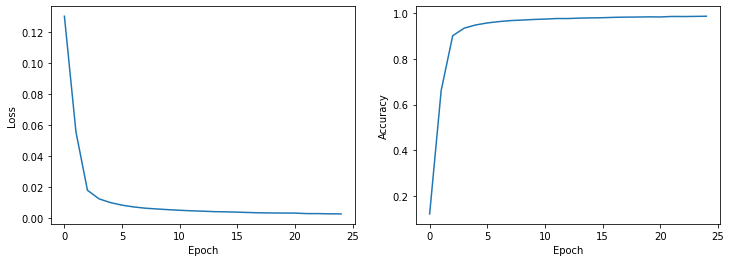

In [247]:
rotation_image_embed_net = ImageEmbedNet()
rotation_classify_net = ClassifyNet(8)
mnist_rotation_classify_model = ImageClassifyModel(rotation_image_embed_net, 
                                                   rotation_classify_net)
train(train_rotation_dataset, mnist_rotation_classify_model, 16, 25)

As you should see, the network manages to get quite good at predicting rotations, with around 0.98 accuracy.

We should once again get testing accuracy similar to training accuracy (around 0.98):

In [249]:
test(test_rotation_dataset, mnist_rotation_classify_model, 16)

Testing Accuracy: 0.980


# Fine-Tuning for Fashion MNIST classification

Now that we have pretrained our model on the rotation prediction task, let's reuse the image embed part of it to train it for the task of class classification. We will use load_state_dict to transfer over the weights from the trained model to a new instance of it, so we can later re-use the same representation learning weights in a different setup. Let's first try it on the full dataset and see how fast it converges compared to when we did not pretrain it.

Training for one epoch: 100%|██████████| 3750/3750 [00:18<00:00, 204.29it/s]


Epoch 0 - Training loss: 0.145 , Training Accuracy: 0.072



Training for one epoch: 100%|██████████| 3750/3750 [00:37<00:00, 99.84it/s] 


Epoch 1 - Training loss: 0.027 , Training Accuracy: 0.844



Training for one epoch: 100%|██████████| 3750/3750 [00:37<00:00, 99.63it/s] 


Epoch 2 - Training loss: 0.017 , Training Accuracy: 0.901



Training for one epoch: 100%|██████████| 3750/3750 [00:37<00:00, 101.16it/s]


Epoch 3 - Training loss: 0.014 , Training Accuracy: 0.916



Training for one epoch: 100%|██████████| 3750/3750 [00:37<00:00, 100.60it/s]


Epoch 4 - Training loss: 0.013 , Training Accuracy: 0.925



Training for one epoch: 100%|██████████| 3750/3750 [00:37<00:00, 100.40it/s]


Epoch 5 - Training loss: 0.011 , Training Accuracy: 0.933



Training for one epoch: 100%|██████████| 3750/3750 [00:37<00:00, 100.86it/s]


Epoch 6 - Training loss: 0.010 , Training Accuracy: 0.941



Training for one epoch: 100%|██████████| 3750/3750 [00:37<00:00, 100.05it/s]


Epoch 7 - Training loss: 0.009 , Training Accuracy: 0.945



Training for one epoch: 100%|██████████| 3750/3750 [00:37<00:00, 100.68it/s]


Epoch 8 - Training loss: 0.008 , Training Accuracy: 0.952



Training for one epoch: 100%|██████████| 3750/3750 [00:37<00:00, 100.76it/s]


Epoch 9 - Training loss: 0.008 , Training Accuracy: 0.955



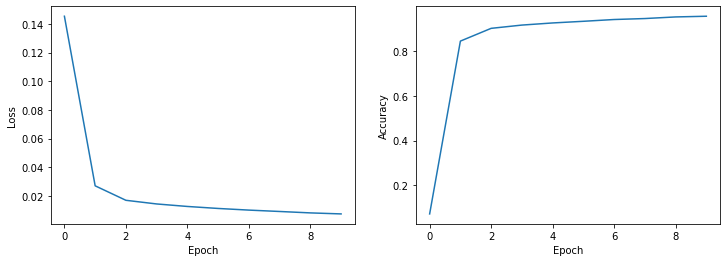

In [253]:
image_embed_net = ImageEmbedNet()
image_embed_net.load_state_dict(rotation_image_embed_net.state_dict())
classify_net = ClassifyNet(10)
mnist_classify_model = ImageClassifyModel(image_embed_net, classify_net)
train(train_full_dataset, mnist_classify_model, 16, 10)

In [254]:
test(test_full_dataset, mnist_classify_model, 16)

Testing Accuracy: 0.907


As we can see, it improves faster and achieves better train and test performance, although the improvement is not huge.

Now, let's try training with the small dataset again and see how well that works:

Training for one epoch: 100%|██████████| 188/188 [00:00<00:00, 207.13it/s]


Epoch 0 - Training loss: 0.145 , Training Accuracy: 0.106



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 102.77it/s]


Epoch 1 - Training loss: 0.088 , Training Accuracy: 0.485



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 101.17it/s]


Epoch 2 - Training loss: 0.038 , Training Accuracy: 0.781



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 99.25it/s] 


Epoch 3 - Training loss: 0.029 , Training Accuracy: 0.830



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 101.76it/s]


Epoch 4 - Training loss: 0.025 , Training Accuracy: 0.857



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 101.82it/s]


Epoch 5 - Training loss: 0.023 , Training Accuracy: 0.865



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 100.93it/s]


Epoch 6 - Training loss: 0.021 , Training Accuracy: 0.880



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 102.00it/s]


Epoch 7 - Training loss: 0.019 , Training Accuracy: 0.897



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 102.12it/s]


Epoch 8 - Training loss: 0.017 , Training Accuracy: 0.909



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 99.88it/s] 


Epoch 9 - Training loss: 0.016 , Training Accuracy: 0.910



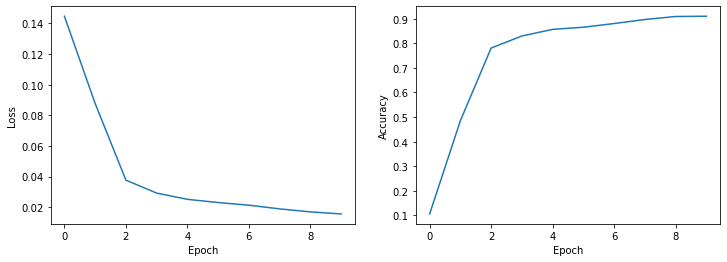

In [256]:
image_embed_net = ImageEmbedNet()
image_embed_net.load_state_dict(rotation_image_embed_net.state_dict())
classify_net = ClassifyNet(10)
mnist_classify_model = ImageClassifyModel(image_embed_net, classify_net)
train(train_small_dataset, mnist_classify_model, 16, 10)

In [257]:
test(test_full_dataset, mnist_classify_model, 16)

Testing Accuracy: 0.856


Now we can see that the with the smaller dataset the pretrained features make a lot of difference, as we get a substantial improvement in training and test accuracy! 

What if we just train for longer? With such a small training dataset, it's possible to achieve perfect accuracy:

Training for one epoch: 100%|██████████| 188/188 [00:00<00:00, 207.66it/s]


Epoch 0 - Training loss: 0.146 , Training Accuracy: 0.106



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 102.58it/s]


Epoch 1 - Training loss: 0.093 , Training Accuracy: 0.507



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 100.00it/s]


Epoch 2 - Training loss: 0.038 , Training Accuracy: 0.780



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 102.60it/s]


Epoch 3 - Training loss: 0.029 , Training Accuracy: 0.823



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 100.80it/s]


Epoch 4 - Training loss: 0.027 , Training Accuracy: 0.850



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 100.55it/s]


Epoch 5 - Training loss: 0.023 , Training Accuracy: 0.874



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 101.41it/s]


Epoch 6 - Training loss: 0.021 , Training Accuracy: 0.885



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 99.37it/s] 


Epoch 7 - Training loss: 0.019 , Training Accuracy: 0.891



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 100.47it/s]


Epoch 8 - Training loss: 0.018 , Training Accuracy: 0.899



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 101.23it/s]


Epoch 9 - Training loss: 0.016 , Training Accuracy: 0.906



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 101.95it/s]


Epoch 10 - Training loss: 0.016 , Training Accuracy: 0.913



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 101.75it/s]


Epoch 11 - Training loss: 0.014 , Training Accuracy: 0.920



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 102.11it/s]


Epoch 12 - Training loss: 0.013 , Training Accuracy: 0.926



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 101.01it/s]


Epoch 13 - Training loss: 0.012 , Training Accuracy: 0.935



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 102.05it/s]


Epoch 14 - Training loss: 0.011 , Training Accuracy: 0.941



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 100.97it/s]


Epoch 15 - Training loss: 0.010 , Training Accuracy: 0.945



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 102.83it/s]


Epoch 16 - Training loss: 0.009 , Training Accuracy: 0.948



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 99.90it/s] 


Epoch 17 - Training loss: 0.009 , Training Accuracy: 0.950



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 100.72it/s]


Epoch 18 - Training loss: 0.008 , Training Accuracy: 0.957



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 97.98it/s] 


Epoch 19 - Training loss: 0.007 , Training Accuracy: 0.957



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 101.66it/s]


Epoch 20 - Training loss: 0.007 , Training Accuracy: 0.962



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 101.64it/s]


Epoch 21 - Training loss: 0.006 , Training Accuracy: 0.970



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 101.57it/s]


Epoch 22 - Training loss: 0.006 , Training Accuracy: 0.965



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 100.21it/s]


Epoch 23 - Training loss: 0.005 , Training Accuracy: 0.977



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 100.14it/s]


Epoch 24 - Training loss: 0.005 , Training Accuracy: 0.974



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 100.08it/s]


Epoch 25 - Training loss: 0.004 , Training Accuracy: 0.978



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 100.16it/s]


Epoch 26 - Training loss: 0.004 , Training Accuracy: 0.978



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 100.63it/s]


Epoch 27 - Training loss: 0.004 , Training Accuracy: 0.983



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 99.60it/s]


Epoch 28 - Training loss: 0.004 , Training Accuracy: 0.982



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 95.14it/s]


Epoch 29 - Training loss: 0.003 , Training Accuracy: 0.985



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 102.58it/s]


Epoch 30 - Training loss: 0.003 , Training Accuracy: 0.986



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 100.92it/s]


Epoch 31 - Training loss: 0.002 , Training Accuracy: 0.993



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 100.18it/s]


Epoch 32 - Training loss: 0.002 , Training Accuracy: 0.993



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 101.13it/s]


Epoch 33 - Training loss: 0.002 , Training Accuracy: 0.994



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 101.00it/s]


Epoch 34 - Training loss: 0.002 , Training Accuracy: 0.991



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 101.89it/s]


Epoch 35 - Training loss: 0.002 , Training Accuracy: 0.993



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 99.09it/s] 


Epoch 36 - Training loss: 0.001 , Training Accuracy: 0.997



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 101.24it/s]


Epoch 37 - Training loss: 0.001 , Training Accuracy: 0.995



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 100.00it/s]


Epoch 38 - Training loss: 0.001 , Training Accuracy: 0.995



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 100.32it/s]


Epoch 39 - Training loss: 0.001 , Training Accuracy: 0.999



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 100.94it/s]


Epoch 40 - Training loss: 0.001 , Training Accuracy: 1.000



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 102.55it/s]


Epoch 41 - Training loss: 0.000 , Training Accuracy: 0.999



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 100.61it/s]


Epoch 42 - Training loss: 0.001 , Training Accuracy: 0.992



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 101.52it/s]


Epoch 43 - Training loss: 0.002 , Training Accuracy: 0.994



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 99.80it/s] 


Epoch 44 - Training loss: 0.001 , Training Accuracy: 0.995



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 100.46it/s]


Epoch 45 - Training loss: 0.000 , Training Accuracy: 1.000



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 101.41it/s]


Epoch 46 - Training loss: 0.000 , Training Accuracy: 1.000



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 101.81it/s]


Epoch 47 - Training loss: 0.000 , Training Accuracy: 1.000



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 99.72it/s] 


Epoch 48 - Training loss: 0.000 , Training Accuracy: 1.000



Training for one epoch: 100%|██████████| 188/188 [00:01<00:00, 100.93it/s]


Epoch 49 - Training loss: 0.000 , Training Accuracy: 1.000



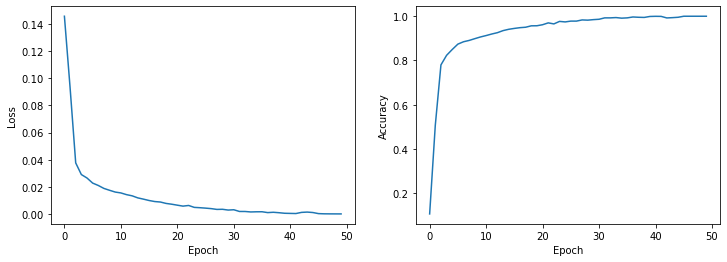

In [258]:
image_embed_net = ImageEmbedNet()
image_embed_net.load_state_dict(rotation_image_embed_net.state_dict())
classify_net = ClassifyNet(10)
mnist_classify_model = ImageClassifyModel(image_embed_net, classify_net)
train(train_small_dataset, mnist_classify_model, 16, 50)

In [259]:
test(test_full_dataset, mnist_classify_model, 16)

Testing Accuracy: 0.859


As we can see, while training for longer on the small dataset gets perfect train accuracy, the test accuracy is no better than what we got before. Part of the benefit of having pre-trained features is greater robustness to this sort of overfitting.

# Conclusion

That's it! As noted in the PDF, you just need to include some of the images from above in your written report, and upload your code to the autograder assignment as usual.